In [1]:
# define libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
#import multiprocessing as mp
import re
from astropy.io import fits
import wquantiles as wq

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# function to check whether variable is a number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
# function to find an index of an element in a sorted list (faster than numpy)
def bissec(A,x):
    n = len(A)-1
    if (x < A[0]):
        return 0
    elif (x > A[n]):
        return n+1
    n1 = 0
    n2 = n
    while ((n2-n1)>1):
        nm = (n1+n2)/2
        if ((x-A[nm]) > 0):
            n1 = nm
        else:
            n2 = nm
    return n1

In [4]:
# this function builds the flag.dat file containing etoile input parameters
def genflag(type):
    
    global lwlim
    global uwlim
    parset = {'derrv': 0, 'deratmos': 0, 'compare': 0}
    parset[type] = 1
    with open('flag.dat', 'w') as flgfil:
        flgfil.write('DERIVE_RADIAL_VELOCITY....... '+str(parset['derrv'])+
                     '\n     write_logs................... 2\n \nNormalise_Object_Continuum... 1'
                     '\n     display_spectrum............. 0\n     reject_high.................. 0'
                     '\n     degree....................... 4\n     sigma_rej.................... 1.8'
                     '\n     nb_kept_pixel_min............ 15\n \nNormalise_Object_Fluxes...... 1\n '
                     '\nSelect_Wavelength_Domain_Temp 1\n     wave_blue.................... '+'%.2f'%lwlim+'\n     '
                     'wave_red..................... '+'%.2f'%uwlim+'\n \nNormalise_Template_Continuum. 1\n     '
                     'display_spectrum............. 0\n     reject_high.................. 0\n     '
                     'degree....................... 4\n     sigma_rej.................... 1.8\n     '
                     'nb_kept_pixel_min............ 15\n \nNormalise_Template_Fluxes.... 1\n \n'
                     'Prepare_Both_Spectra......... 0\n     vmax......................... 700.0\n \n'
                     'Calculate_Analyse_CC_Peak\n     nbst0........................  60\n     '
                     'nbst1........................ 225\n     step0........................  10.0\n     '
                     'step1........................   0.2\n \nDisplay_Overplotted_Spectra.. 1\n \n     '
                     '-----------------------------------\n \nLIBRARY_OF_ATMOSPHERIC_PARAMETERS\n'
                     'Param_Std ../code/dnm/parameters_standard_V20130201.dat\n\n     '
                     '-----------------------------------\n \nCOMPARE_SPECTRA.............. '+
                     str(parset['compare'])+'\nDERIVE_ATMOSPHERIC_PARAMETERS '+
                     str(parset['deratmos'])+'\n     Match_Orders................. 0\n     '
                     'Convolve..................... 0\n     Graph........................ 0\n     '
                     'Write........................ 1\n     Number_Of_Degrees_Of_Freedom. 4')

In [5]:
# set parameters to run etoile in one line depending on goal (derive RV, derive atmos.param., compare)

def run_etoile(inptf, lib, modeconf):
    
    #simplifying the name
    sname = inptf.split('.')[0]
    #logging etoile outputs
    logf = open('etoile_'+sname+'.log', 'w')
    print('running etoile for '+sname+' ...'),
    #Etoile is open in a subprocess
    pr = sp.Popen(['./etoile'], shell=True, close_fds=True,
             stdin=sp.PIPE, stdout=logf)
    #depending on the running mode, different inputs must be given
    if modeconf['deratmos'] == 1:
        pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n'+str(lib)+'\n')
    elif modeconf['derrv'] != 0:
        pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n'+str(lib)+'\n2.5\n')
    elif modeconf['compare'] != 0:
        if is_number(modeconf['compare']):
            #if the key 'compare' is a number, it must represent a library index
            pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n'+str(lib)+'\n'+str(modeconf['compare'])+'\n')
        else:
            #if not, must be a filename
            prefix = modeconf['compare'].split('.')[0]
            pr.communicate('0\n'+inptf+'\n'+inptf.split('.')[0]+'\n0\n'+modeconf['compare']+'\n'+prefix+'\n')
    print(' done.')

In [6]:
def noise_est(spec, region, order):
    
    def poly(x, coefs):
        value = 0
        for k in range(len(coefs)):
            value += coefs[-(k+1)]*x**k
        return value
    
    coef = np.polyfit(spec[0], spec[1], order)
    norf = poly(spec[0], coef)
    specn = spec[1]/norf
    specnr = specn[bissec(spec[0], region[0]):bissec(spec[0], region[1])]
    return np.mean(specnr)/np.std(specnr), norf

In [7]:
# this cell creates a dictionary with all spectra from all OBs and their parameters (S/N, OB.ID, star.ID, filename)

# wavelength limit to trim the input spectra
lwlim = 4800
uwlim = 7000
lib = 0 #specifying that the comparison will be made with a custom star
ovcp = 4 #over-cut pixels on etoile master star to fit the rebinning (ensure that target spectral wavelength range < library spectrum w.r.)

#extract ascii from PampelMuse output

star_db = {}

#the directory containing PampelMUSE direct outputs. the name prefixes must have the format <CLUSTER_NAME>_<OBID><PampelMUSE automatic name starting with id...>
sdir = 'spec'

for file in os.listdir(sdir):
    #this loop automatically identifies .fits files, extract the spectrum and its S/N ratio, and save the ascii
    #file within the root directory of this script, usually Etoile's running directory
    if file.endswith(".fits"):
        flnm = os.path.join(sdir, file)
        #using regex to identify object, OB and star ID
        filid = re.split('[(_)(id)(jd)]+', file.strip('.fits'))
        obj = filid[0]
        run = filid[1]
        oid = '%04d'%int(filid[2])
        #opening .fits file
        hl = fits.open(flnm)
        hd = hl[0].header
        #reading lamba and binning data from header
        rfp = hd['CRVAL1']*1E10
        dlt = hd['CDELT1']*1E10
        snr = hd['HIERARCH SPECTRUM SNRATIO']
        #reading flux falues
        flx = hl[0].data
        nps = len(flx)
        #building wavelength array
        lsl = rfp + dlt * (nps - 1)
        lbd = np.linspace(rfp, lsl, nps)
        #extracted filename
        xfl = obj+'_'+run+'_'+oid+'.ascii'
        #cutting spectrum based on lambdas provided
        cutidxs = [bissec(lbd, lwlim), bissec(lbd, uwlim)]
        lbd = lbd[cutidxs[0]:cutidxs[1]]
        flx = flx[cutidxs[0]:cutidxs[1]]
        #sometimes extracted spectra comes with negative values, so here we correct this by
        #simply adding the flux of the lowest value + 1 to the whole spectrum
        if min(flx) < 0:
            flx = flx + abs(min(flx))+1
        nps = len(flx)
        spdata = np.transpose([lbd, flx])
        #here we save the extracted spectrum
        np.savetxt(xfl, spdata, header=str(nps), comments='')
        #now we build the database and write the filename and the S/N into it
        if obj not in star_db.keys():
            star_db[obj] = {}
        if oid not in star_db[obj].keys():
            star_db[obj][oid] = {}
        if run not in star_db[obj][oid].keys():
            star_db[obj][oid][run] = {'fname': xfl, 'snr': snr}
print(star_db)

{'Ter9': {'0077': {'OB5': {'snr': 47.29958883200229, 'fname': 'Ter9_OB5_0077.ascii'}, 'OB3': {'snr': 51.93446373567183, 'fname': 'Ter9_OB3_0077.ascii'}, 'OB1': {'snr': 52.39833269995351, 'fname': 'Ter9_OB1_0077.ascii'}}, '2034': {'OB4': {'snr': 163.6337275487833, 'fname': 'Ter9_OB4_2034.ascii'}, 'OB5': {'snr': 93.60027919753881, 'fname': 'Ter9_OB5_2034.ascii'}, 'OB2': {'snr': 124.4365408936424, 'fname': 'Ter9_OB2_2034.ascii'}, 'OB3': {'snr': 137.2969179437681, 'fname': 'Ter9_OB3_2034.ascii'}, 'OB1': {'snr': 135.666904427836, 'fname': 'Ter9_OB1_2034.ascii'}}, '3258': {'OB4': {'snr': 51.67874222652215, 'fname': 'Ter9_OB4_3258.ascii'}, 'OB2': {'snr': 16.06495534452307, 'fname': 'Ter9_OB2_3258.ascii'}}, '0544': {'OB4': {'snr': 122.4115280924433, 'fname': 'Ter9_OB4_0544.ascii'}, 'OB5': {'snr': 95.51430010199964, 'fname': 'Ter9_OB5_0544.ascii'}, 'OB2': {'snr': 87.23352319990714, 'fname': 'Ter9_OB2_0544.ascii'}, 'OB3': {'snr': 116.2975256806315, 'fname': 'Ter9_OB3_0544.ascii'}, 'OB1': {'snr':

In [8]:
# this cell reads the dictionary, uses the ETOILE to resample lambda and match flux of 
# different spectra of the same star and take their median flux weighted by S/N.


# clean previous runs
try:
    os.remove('atmosphericParameters.dat')
    os.remove('spec2plot.tab')
except:
    pass

%matplotlib inline
reg = [6040, 6060]
#now, for each star, this loop is going to make a 'master' spectrum using the one with the
#highest flux. Since Etoile requires that the base (observed) spectrum has a shorter length
#than the compared ones (library), we trim the master based on all the OB's.
for obj in star_db.keys():
    for star in star_db[obj].keys():
        star_db[obj][star].keys().sort()
        hiflx = -9999
        hiob = ''
        weights = []
        #finding the one with highest flux:
        for ob in star_db[obj][star].keys():
            osp = np.genfromtxt(star_db[obj][star][ob]['fname'], unpack=True, skip_header=1)
            snr, norm = noise_est(osp, reg, 5)
            star_db[obj][star][ob]['snr'] = snr
            weights.append(star_db[obj][star][ob]['snr'])
            star_db[obj][star][ob]['ospec'] = osp
            meanflx = np.mean(osp[1])
            print(meanflx)
            if meanflx > hiflx:
                hiflx = meanflx
                hiob = ob
        
        #trimming the master:
        print(star, hiob)
        mastersp = star_db[obj][star][hiob]['ospec']
        lrej = []
        for ob in star_db[obj][star].keys():
            ospec = star_db[obj][star][ob]['ospec']
            for n, l in enumerate(mastersp[0]):
                if l < ospec[0][0]:
                    if n not in lrej:
                        lrej.append(n)
                if l > ospec[0][-1]:
                    if n not in lrej:
                        lrej.append(n)
        
        #removing some more pixels to assure
        mslb = np.delete(mastersp[0], lrej)[ovcp:-ovcp]
        msfl = np.delete(mastersp[1], lrej)[ovcp:-ovcp]
        #and saving it.
        ovsp = np.transpose([mslb, msfl])
        mtnm = star+'_master.ascii'
        np.savetxt(mtnm, ovsp, header=str(len(mslb)), comments='')
        
        genflag('compare')
        
        #here we run Etoile for each OB (including the one taken as master, but without trimming)
        #to rebin them for the combination
        for ob in star_db[obj][star].keys():
            #we give the master filename as the custom comparing spectrum
            mconf = {'derrv': 0, 'deratmos': 0, 'compare': star_db[obj][star][ob]['fname']}
            run_etoile(mtnm, lib, mconf)
            #now we assign each rebinned spectra to its place in the database
            rbfl = np.genfromtxt('spec2plot.tab', unpack=True, skip_header=1)
            star_db[obj][star][ob]['rbflx'] = rbfl[2]
            star_db[obj][star][ob]['rblbd'] = rbfl[0]
            
            os.remove(star_db[obj][star][ob]['fname'])
            #rbspec = np.transpose([rbfl[0], rbfl[2]])
            #oname = obj+'_'+star+'_'+ob+'_rb.ascii'
            #np.savetxt(oname, rbspec, header=str(len(rbfl[0])), comments='')
            
            #plt.plot(rbfl[0], rbfl[2], lw=0.6, label=ob)
            try:
                os.remove('spec2plot.tab')
            except:
                pass
        os.remove(mtnm)
        
        #now we construct the weighted median flux
        mdfx = []
        weights = np.array(weights)
        #taking the lambda from the reference OB, since all of them are the same
        reflbd = star_db[obj][star][hiob]['rblbd']
        #this loop uses the wq package to take the weighted median for each flux point
        for n, f in enumerate(reflbd):
            fxs = []
            for ob in star_db[obj][star].keys():
                fxs.append(star_db[obj][star][ob]['rbflx'][n])
            fxs = np.array(fxs)
            mdfx.append(wq.median(fxs, weights))
        
        #an issue with Etoile makes it add some zeros to the end of the files
        #we correct this here
        rejl = []
        for n, f in enumerate(mdfx):
            if f == 0:
                rejl.append(n)
        
        #now we save the combined spectrum
        comblb = np.delete(reflbd, rejl)
        combfx = np.delete(mdfx, rejl)
        star_db[obj][star]['combspec'] = [comblb, combfx]
        
        #plt.plot(comblb, combfx ,'k-', lw=0.7, label='combined')
        
        combspec = np.transpose([comblb, combfx])
        try:
            os.mkdir('combined')
        except:
            pass
        cbname = 'combined/'+obj+'_'+star+'cb.ascii'
        np.savetxt(cbname, combspec, header=str(len(comblb)), comments='')

    #plt.show()

8024.23135019
9945.61305507
184654.638261
('0077', 'OB1')
running etoile for 0077_master ...  done.
running etoile for 0077_master ...  done.
running etoile for 0077_master ...  done.
15809.9977955
6573.60070359
193556.197149
12077.9343065
232509.73442
('2034', 'OB1')
running etoile for 2034_master ...  done.
running etoile for 2034_master ...  done.
running etoile for 2034_master ...  done.
running etoile for 2034_master ...  done.
running etoile for 2034_master ...  done.
4578.78034585
38904.6097433
('3258', 'OB2')
running etoile for 3258_master ...  done.
running etoile for 3258_master ...  done.
18925.7382912
9898.16053217
231843.855957
14998.0362851
270027.061124
('0544', 'OB1')
running etoile for 0544_master ...  done.
running etoile for 0544_master ...  done.
running etoile for 0544_master ...  done.
running etoile for 0544_master ...  done.
running etoile for 0544_master ...  done.
1901.4124811
2952.70297338
('1948', 'OB3')
running etoile for 1948_master ...  done.
running etoi

final S/N: 47.46


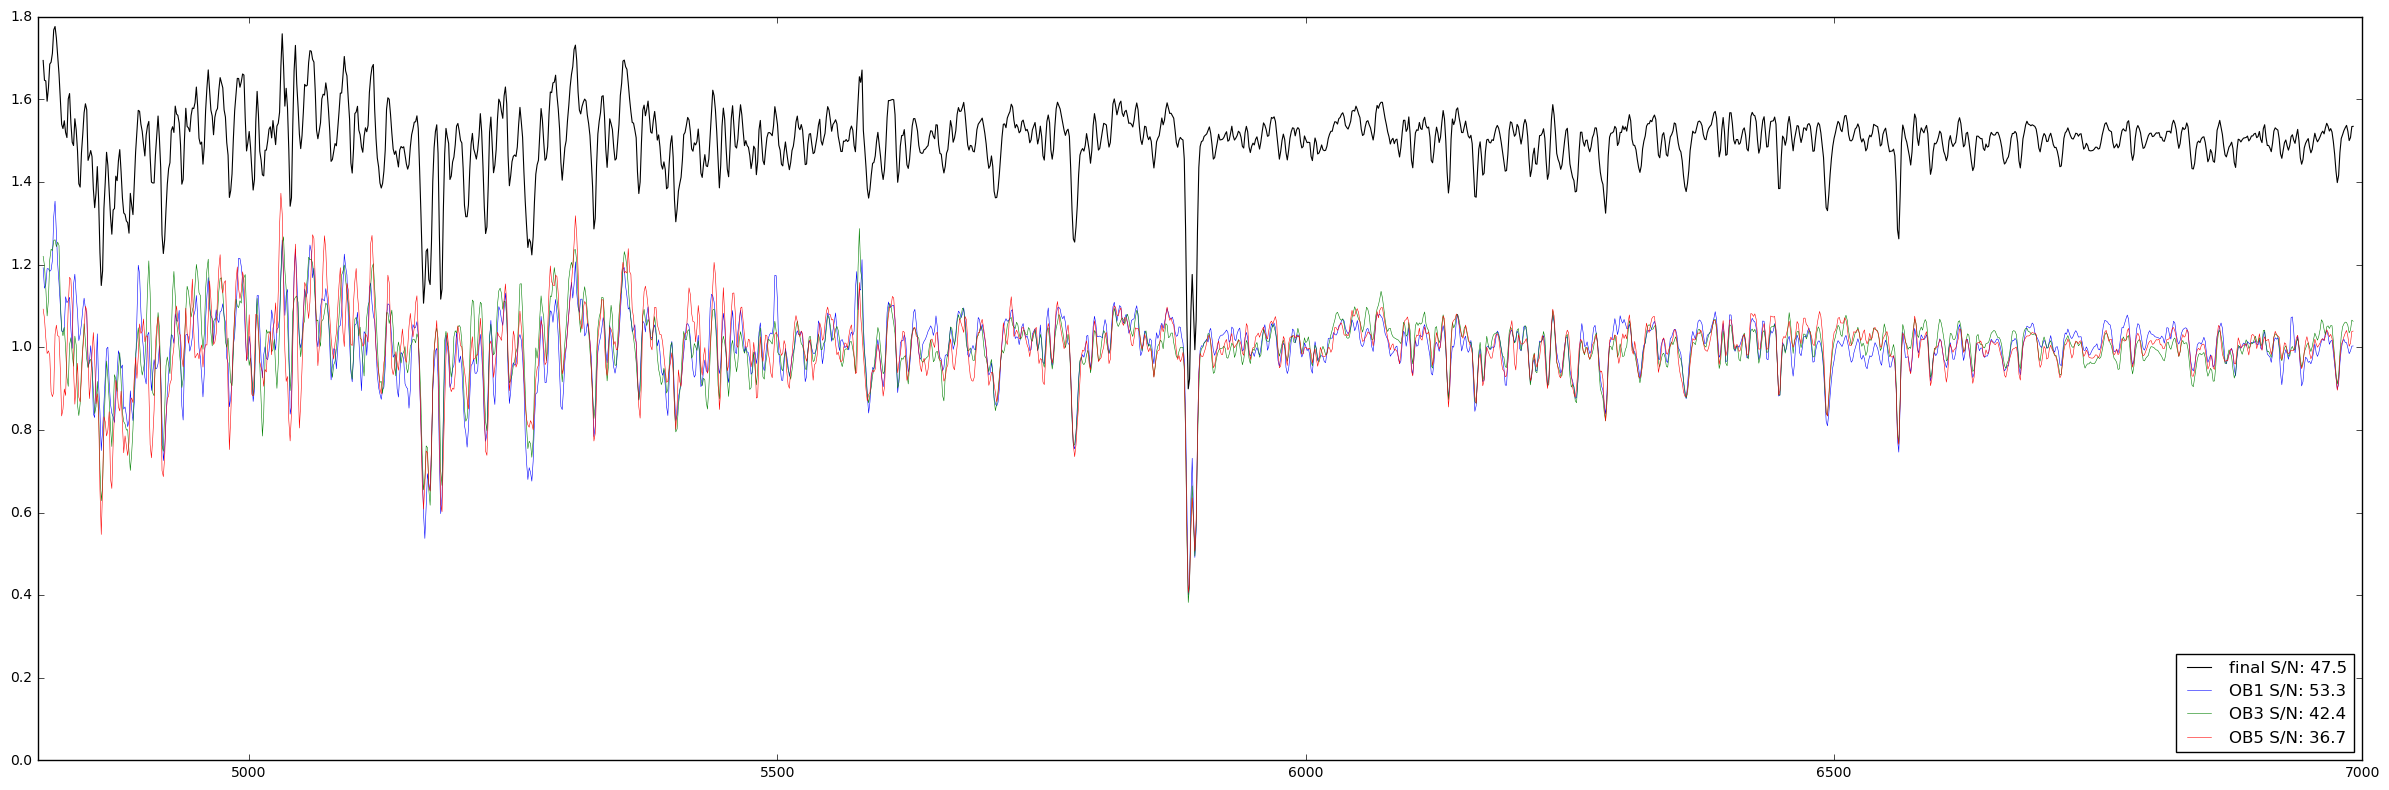

In [28]:
# checking etoile fit (comment lines that delete spec2plot before)
# TBD: generate PDFs for check 
reg = [6040, 6060]
%matplotlib inline
obj = 'Ter9'
star = '0077'
#print('radial velocity: '+str(bestmatch[spname]['rv']))
plt.figure(figsize=(24,8))
snr, norm = noise_est(star_db[obj][star]['combspec'], reg, 9)
#plt.plot(star_db[obj][star]['combspec'][0], star_db[obj][star]['combspec'][1]+0.3, 'k-', lw=0.8,
#         label='final S/N: %.1f'%snr)
plt.plot(star_db[obj][star]['combspec'][0], star_db[obj][star]['combspec'][1]/norm+0.5, 'k-', lw=0.8,
         label='final S/N: %.1f'%snr)
print('final S/N: %.2f'%snr)
#plt.plot(star_db[obj][star]['combspec'][0], norm+0.3, 'r-', lw=1.0)
for obl in sorted(star_db[obj][star].keys()):
    if obl != 'combspec':
        plt.plot(star_db[obj][star][obl]['rblbd'], star_db[obj][star][obl]['rbflx']/norm, lw=0.4,
                 label=obl+' S/N: %.1f'%star_db[obj][star][obl]['snr'])
plt.gca().set_xlim([4800, 7000])
plt.gca().set_ylim([0.0, 1.8])
plt.legend(loc=4)
plt.tight_layout()
fig = plt.gcf()
plt.show()
#fig.savefig(obj+'_'+star+'.eps')
plt.close()

In [10]:
os.system('rm etoile*.log')

0